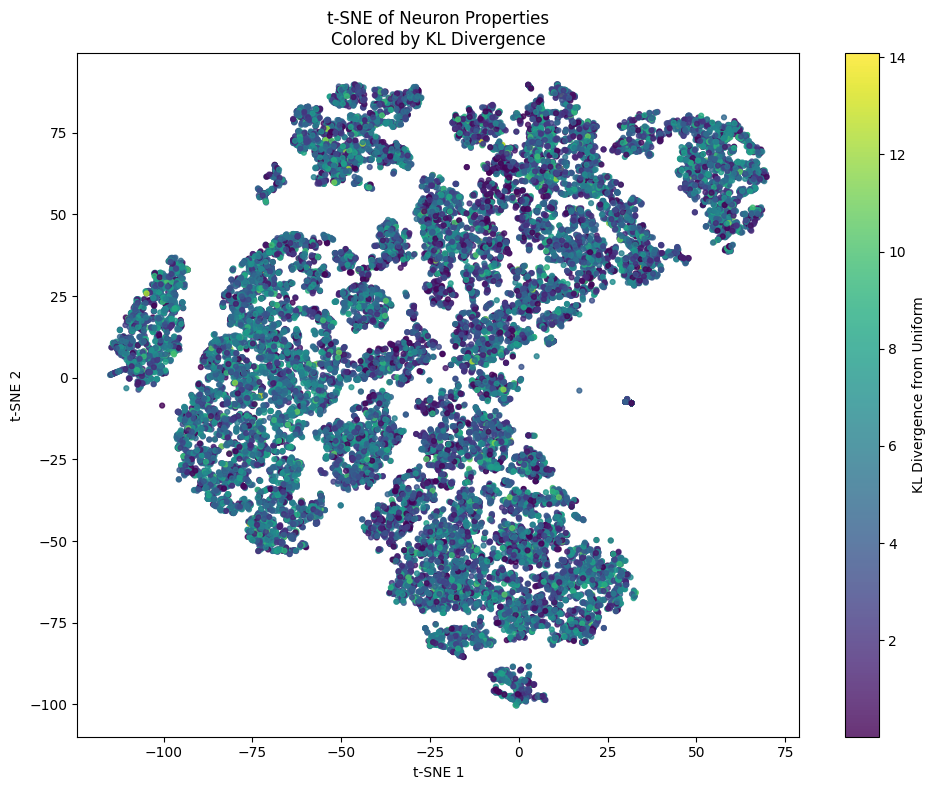

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Load neural response matrix (shape: [n_neurons, 118 images])
dat = np.load('/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses_reduced.npy')

# Step 1: Compute KL divergence from uniform for each neuron
prob_matrix = dat / 50.0  # convert counts to probabilities
epsilon = 1e-10
prob_matrix_safe = prob_matrix + epsilon
num_neurons, num_images = prob_matrix.shape

uniform_dist = np.full((num_images,), 1.0 / num_images)
kl_divs = []
for neuron_probs in prob_matrix_safe:
    neuron_dist = neuron_probs / np.sum(neuron_probs)
    kl = np.sum(uniform_dist * np.log(uniform_dist / neuron_dist))
    kl_divs.append(kl)
kl_divs = np.array(kl_divs)

# Step 2: Load and process neuron property data
cell_df = pd.read_csv("/home/maria/LuckyMouse2/neuron_property_decoding/data/cell_metrics_joined.csv")
cell_df = cell_df.sort_values("data_row_index").reset_index(drop=True)

# Select target properties
targets = [
    'osi_dg', 'dsi_dg', 'g_osi_dg', 'g_dsi_dg',
    'reliability_dg', 'reliability_nm1_a',
    'run_mod_dg', 'tfdi_dg', 'pref_tf_dg',
    'peak_dff_dg'
]
Y_df = cell_df[targets]
Y_df_filled = Y_df.fillna(0.0)
Y = Y_df_filled.to_numpy(dtype=np.float32)

# Step 3: Standardize and run t-SNE
Y_std = StandardScaler().fit_transform(Y)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Y_tsne = tsne.fit_transform(Y_std)

# Step 4: Plot t-SNE with KL divergence color
plt.figure(figsize=(10, 8))
sc = plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1],
                 c=kl_divs, cmap='viridis', s=12, alpha=0.8)
plt.colorbar(sc, label='KL Divergence from Uniform')
plt.title("t-SNE of Neuron Properties\nColored by KL Divergence")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()
